LANGUAGE ANALYSIS OF THE STARDEW VALLEY WIKI


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from wikiscraper import get_scraper_tool, ConfigLoader

# Language confidence score function

In [20]:
from wordfreq import top_n_list


def language_confidence_score(word_counts: pd.DataFrame, lang: str, k: int) -> float:
    top_words_lang = set(top_n_list(lang, k))

    if word_counts.empty:
        return 0.0

    total_words_in_article = word_counts['wiki freq'].sum()

    if total_words_in_article == 0:
        return 0.0

    matched_words = word_counts[word_counts['word'].isin(top_words_lang)]
    score_sum = matched_words['wiki freq'].sum()

    return score_sum / total_words_in_article

# Input data - scrape and off-wiki text preparation

In [21]:
from analysis import TextAnalyzer
from pathlib import Path

config = ConfigLoader(Path("./analysis_configs/config_en.json"))
scraper = get_scraper_tool(config)

data_sources = {}

html_long = scraper.fetch_page("Sebastian")
data_sources['Wiki Long Article'] = TextAnalyzer.sum_word_occurrences(scraper.extract_all_words(html_long))

html_bad = scraper.fetch_page("Radish Salad")
data_sources['Wiki Weird Article'] = TextAnalyzer.sum_word_occurrences(scraper.extract_all_words(html_bad))

languages = ['en', 'de', 'pl']

for lang in languages:
    with open(f"offwiki_texts/{lang}.txt", "r", encoding="utf-8") as f:
        text = f.read()

    df = pd.DataFrame(text.lower().split(), columns=['word'])
    data_sources[f'Text from outside of the wiki in {lang.upper()} language'] = TextAnalyzer.sum_word_occurrences(df)

In [22]:
languages_to_test = ['en', 'de', 'pl']
k_values = [3, 10, 100, 1000]

results = []

for source_name, df_words in data_sources.items():
    for lang in languages_to_test:
        for k in k_values:
            score = language_confidence_score(df_words, lang, k)
            results.append({
                'Source': source_name,
                'Language': lang,
                'k': k,
                'Score': score
            })

df_results = pd.DataFrame(results)


# Plot generation

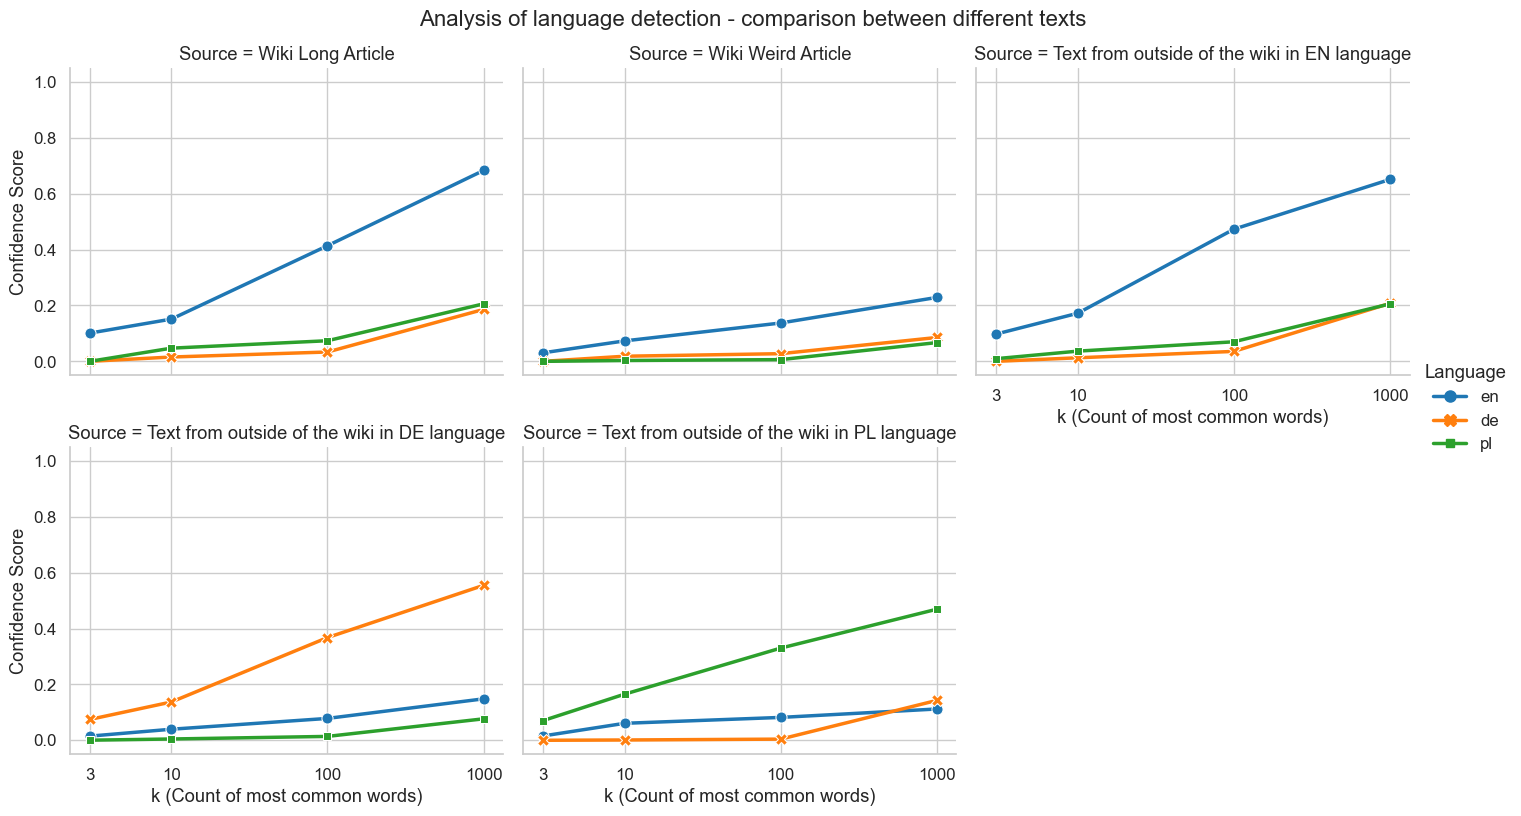

In [23]:
import seaborn as sns
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
palette = {"en": "#1f77b4", "de": "#ff7f0e", "pl": "#2ca02c"} # Kolory (niebieski, pomarańczowy, zielony)

g = sns.relplot(
    data=df_results,
    x="k",
    y="Score",
    hue="Language",
    style="Language",
    col="Source",
    col_wrap=3,
    kind="line",
    markers=True,
    dashes=False,
    height=4,
    aspect=1.2,
    palette=palette,
    linewidth=2.5,
    markersize=8
)

g.set(xscale="log")
g.set(xticks=[3, 10, 100, 1000])
g.set_xticklabels([3, 10, 100, 1000])
g.set(ylim=(-0.05, 1.05))

g.set_axis_labels("k (Count of most common words)", "Confidence Score")
g.fig.suptitle("Analysis of language detection - comparison between different texts", y=1.02, fontsize=16)


plt.show()

# Komentarz do wyników:

## Skuteczność ogólna:
Metoda poprawnie identyfikuje język dominujący dla wszystkich próbek tekstowych. Wraz ze wzrostem $k$, pewność klasyfikacji (Confidence Score) rośnie, co jest widoczne na wykresach jako wyraźne oddalenie się linii języka właściwego od pozostałych.
## Wpływ długości tekstu:
Dla artykułów narracyjnych (Wiki Long Article) oraz tekstów spoza wiki, funkcja osiąga stabilne i wysokie wartości. Wynika to z faktu, że dłuższy tekst lepiej reprezentuje statystyczny rozkład słów w danym języku.
## Istotność doboru języków:
Dobór języków (angielski, polski, niemiecki) miał istotne znaczenie dla weryfikacji odporności algorytmu. Dzięki temu, że języki te należą do różnych grup (germańskie vs. słowiańskie) i charakteryzują się różnym stopniem fleksji, można było zaobserwować, że zbiory $k$ najczęstszych słów są niemal całkowicie rozłączne. Zapobiegło to przypadkowym "fałszywym trafieniom" między językami.
## Widoczność odmiany w danych:
Jest to wyraźnie widoczne przy porównaniu wyników dla języka angielskiego i polskiego. W przypadku języka polskiego wartość lang_confidence_score dla $k=1000$ jest niższa niż dla angielskiego o podobnej długości. Wynika to z faktu, że polskie słowa w tekście przyjmują wiele form (odmiana przez przypadki, liczby, osoby), które nie figurują w słowniku $k$ najczęstszych form podstawowych, co obniża wynik dopasowania.
## Trudność znalezienia "najgorszego" artykułu:
Znalezienie artykułu o niskim wyniku (Wiki Weird Article) nie było trudne ze względu na specyfikę Stardew Valley Wiki. Wiele stron na tej wiki to techniczne zestawienia imion (jak na zawartym przykładzie), mebli, przedmiotów czy parametrów technicznych. Ponieważ składają się one głównie z nazw własnych i statystyk, a nie z naturalnych zdań, zawierają bardzo mało "słów funkcyjnych" (jak the, and, is), co drastycznie obniża wynik pewności języka, mimo że technicznie jest to tekst angielski